In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


In [5]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [6]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [12]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


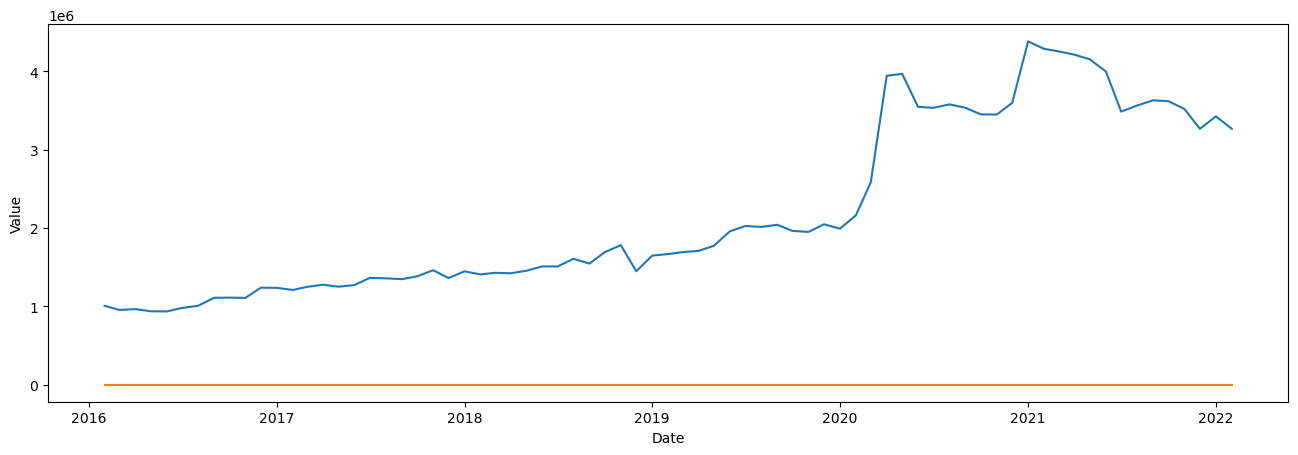

In [14]:
plot_df(retailEcommercesales_ts)

In [21]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

In [22]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,60,0,...,0,0,54,40,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,44,46,0,0,0,0,0


In [23]:
def get_long_term_trend(dataframe, freq='M'):
    """extract the monthly trend from the series"""
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias and downward trend"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


def make_predictors_df(*arg):
    """joins the predictors dataframes"""
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

def normalize(dataframe):
    """function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df

# difference
def detrend(dataframe):
    """function to detrend time series"""
    return dataframe.diff().dropna()

# seasonality
def remove_seasonality(dataframe):
    """function for differencing of time series"""
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data

# cyclicity 
def remove_volatility(dataframe):
    """function for removing volatility of time series"""
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)
    

In [27]:
gdp_category_data = pd.read_csv("gdp_category_ts.csv", index_col = 0)
gdp_category_data.rename(index={'date': 'Date'}, inplace=True)
gdp_category_data.index = pd.to_datetime(gdp_category_data.index) 
gdp_category_data.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='date', length=220, freq=None)

In [25]:
retailEcommercesales = retailEcommercesales.set_index(['Date'])
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)
retailEcommercesales.head(2)

,Ecommerce_sales
Date,
2016-01-01,977198
2016-02-01,1006610


In [33]:
# correlation check
cols = list()
data = pd.merge(retailEcommercesales, gdp_category_data, left_index=True, right_index=True)

for i in range(0, data.iloc[:,2:].shape[1]):
    corr, _ = pearsonr(data['Ecommerce_sales'], data.iloc[:, i+2])
    if abs(corr) > 0.9:
        cols.append(data.columns[i+2])

In [34]:
len(cols)

3

In [35]:
gdp_ecommerce_correlated_data = data[cols]

In [36]:
gdp_ecommerce_correlated_data

,23,726,882
2016-01-01,32,62,58
2016-02-01,31,64,59
2016-03-01,29,68,57
2016-04-01,33,66,62
2016-05-01,33,67,61
...,...,...,...
2021-10-01,20,37,72
2021-11-01,24,37,73
2021-12-01,25,38,72
2022-01-01,21,40,77


In [ ]:
gdp_ecommerce_correlated_data.columns

In [ ]:
keyword_category_merged = pd.merge(ecommerce_keyword_ts,gdp_ecommerce_correlated_data,left_index=True, right_index=True)

In [ ]:
keyword_category_merged.head(2)

In [ ]:
#keyword_category_merged.drop('95', axis=1, inplace=True)
normalized_merged_keyword = normalize(keyword_category_merged)
detrend_merged_keyword = ((detrend(detrend(normalized_merged_keyword))))
check_stationarity(detrend_merged_keyword)

In [ ]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],detrend_merged_keyword, 0.2)

In [ ]:
lag_plots(retailEcommercesales_ts[['Growth_rate']])

#### Xgboost model

In [ ]:
def get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts, dependent_var='Growth_rate'):
    """ passed response dataframe and predictors' dataframe"""
    lasso_key = detrend(normalize(ecommerce_keyword_ts))

    # response
    lasso_response = retailEcommercesales_ts[[dependent_var]].iloc[1:,:]

    # extract lag1 data to add to predictors
    lag1 = retailEcommercesales_ts[[dependent_var]].iloc[0:retailEcommercesales_ts.shape[0]-1,:]
    lag1.index = lasso_response.index
    lag1 = lag1.rename(columns={dependent_var: 'lag1'}) 
    lasso_predictors = make_predictors_df(lag1, lasso_key)
    return lasso_predictors, lasso_response

def xgboost_modelfit(train_xgboost, dependent_var='Growth_rate'):
    """ fits xgboost model to the passed data"""
    X_xgboost, Y_xgboost = train_xgboost.loc[:, ~train_xgboost.columns.isin([dependent_var])], train_xgboost[[dependent_var]]
    xgboostmodel = XGBRegressor(objective ='reg:squarederror', n_estimators=1000)
    xgboostmodel.fit(X_xgboost, Y_xgboost)
    return xgboostmodel



In [ ]:
# predictor lag1
xgboost_predictors, xgboost_response = get_lag1_data(retailEcommercesales_ts, detrend_merged_keyword)

#model fitted on data split

train_xgboost, test_xgboost, _ = ts_train_test_split(xgboost_response, xgboost_predictors, test_size=0.2)
xgboostmodel = xgboost_modelfit(train_xgboost)
train_xgboost.shape

In [ ]:
#  split the data

trainX, trainy = train_xgboost.iloc[:, 1:], train_xgboost['Growth_rate']
testX, testy = test_xgboost.iloc[:, 1:], test_xgboost.iloc[:, -0]

In [ ]:
# predictions

fitted_growthRate_xgboost = xgboostmodel.predict(trainX)
fitted_growthRate_xgboost.squeeze()
fitted_growthRate_xgboost = pd.DataFrame(fitted_growthRate_xgboost, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_xgboost.index = train_xgboost.index

In [ ]:
# growth rate prediction

fitted_values_xgboost = pd.DataFrame({'GrowthRate': train_xgboost['Growth_rate'],
                              'Fitted Value': fitted_growthRate_xgboost.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

In [ ]:
def rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate'):
    """ Rolling prediction for xgboost"""
    train_samples = train_xgboost.shape[0]
    test_samples = test_xgboost.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test_xgboost.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = xgboost_modelfit(train_xgboost)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test_xgboost.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train_xgboost = pd.concat([train_xgboost, firstrow_test])

        # Drop first row from test set now
        test_xgboost = test_xgboost.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

In [ ]:
xgboost_pred_salesgrowth = rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate')

In [ ]:
# fitted and predicted plot of growth rate

fitted_values_xgboost = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_xgboost.squeeze(),
                                'Predicted Value': xgboost_pred_salesgrowth.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

In [ ]:
def fitted_and_predicted_sales_xgboost(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test):
    base_sales = retailEcommercesales['Ecommerce_sales'][1]

    # calculate fitted gdp
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted EcommerceSales_GrowthRate'})
    fitted_values.index = train.index

    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted EcommerceSales_GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*(len(pred_EcommerceGrowth.squeeze()))
    actual_sales = base_sales_test
    for i, value in enumerate(pred_EcommerceGrowth.squeeze()):
        predicted_sales[i] = actual_sales*(1 + value)
        actual_sales = retailEcommercesales.loc[test.index[i]][0]
    predicted_sales_df = pd.DataFrame(predicted_sales)
    predicted_sales_df.index = pred_EcommerceGrowth.index
    predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

    # prediction error calculation
    org = retailEcommercesales[retailEcommercesales.index >= predicted_sales_df.index[0]]
    error = 0
    for i in range(0, predicted_sales_df.shape[0]):
        error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
    pred_error = np.sqrt(error/predicted_sales_df.shape[0])
    print(f"Prediction error: {pred_error}")

    # Plot actual and fitted GDP
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual EcommerceSales': Actual_sales,
                                        'Fitted EcommerceSales': fitted_sales_df.squeeze(),
                                        'Predicted EcommerceSales': predicted_sales_df.squeeze()
                                       })
    plot_df(fittedandActual_sales, width=10, height=3)
    return pred_error, fittedandActual_sales

In [ ]:
# fitted and predicted plot

plot_sales, actual_sales = fitted_and_predicted_sales_xgboost(xgboostmodel, xgboost_pred_salesgrowth, retailEcommercesales, train_xgboost, test_xgboost)
plot_sales

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',learning_rate = 0.01, n_estimators = 500,subsample=0.8, colsample_bytree=0.85)

In [ ]:
# predictions
xg_reg.fit(trainX,trainy)
fitted_growthRate_xgboost = xg_reg.predict(trainX)
fitted_growthRate_xgboost.squeeze()
fitted_growthRate_xgboost = pd.DataFrame(fitted_growthRate_xgboost, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_xgboost.index = train_xgboost.index

In [ ]:
xgboost_pred_salesgrowth = rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate')

In [ ]:
# fitted and predicted plot of growth rate

fitted_values_xgboost = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_xgboost.squeeze(),
                                'Predicted Value': xgboost_pred_salesgrowth.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

In [ ]:
# fitted and predicted plot

plot_sales, actual_sales = fitted_and_predicted_sales_xgboost(xg_reg, xgboost_pred_salesgrowth, retailEcommercesales, train_xgboost, test_xgboost)
plot_sales

#### Random Forest

In [ ]:
def randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=100):
    """ fits Random Forest model to the passed data"""
    x_train, y_train = train_rf.loc[:, ~train_rf.columns.isin([dependent_var])], train_rf[[dependent_var]]
    RFmodel = RandomForestRegressor(n_estimators=n_trees)
    RFmodel.fit(x_train, y_train)
    return RFmodel

def rolling_prediction_RF(train, test, dependent_var='Growth_rate',n_trees=100):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = randomForest_modelfit(train, dependent_var,n_trees=100)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

# RF Feature Importance Plot
def plot_feature_importance(importance, names, model_type, most_important_predictors=20):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False)
    fi_df=fi_df[0:most_important_predictors]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Seaborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
# get data for random forest
rf_predictors, rf_response = get_lag1_data(retailEcommercesales_ts, detrend_merged_keyword, dependent_var='Growth_rate')

print(rf_predictors.shape)
print(rf_response.shape)

In [ ]:
# train test split
train_rf, test_rf, _ = ts_train_test_split(rf_response, rf_predictors, test_size=0.2)
train_rf.shape

In [ ]:
# fit model
rfmodel = randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=900)

# fitted growth rate
X_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]
fitted_growthRate_rf = rfmodel.predict(X_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted EcommerceSales_GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

In [ ]:
# Rolling prediction of growth rate

pred_growthrate_rf = rolling_prediction_RF(train_rf, test_rf, dependent_var='Growth_rate',n_trees=900)

In [ ]:
#fitted Ecommerce Sales

fitted_values_rf = pd.DataFrame({'EcommerceSales_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_rf.squeeze(),
                                'Predicted Value': pred_growthrate_rf.squeeze()})
plot_df(fitted_values_rf, width=12, height=4)

In [ ]:
plot_sales, actual_fitted_sales = fitted_and_predicted_sales_xgboost(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf)

#### GDP keyword file

In [ ]:
gdp_keyword_data = pd.read_csv("gdp_keywords_ts.csv")
gdp_keyword_data.rename(columns = {'date':'Date'}, inplace = True)
gdp_keyword_data = gdp_keyword_data.set_index(['Date'])
gdp_keyword_data.index = pd.to_datetime(gdp_keyword_data.index) 
gdp_keyword_data.head()

In [ ]:
# correlation check
cols = list()
data = pd.merge(retailEcommercesales, gdp_keyword_data, left_index=True, right_index=True)

for i in range(0, data.iloc[:,2:].shape[1]):
    corr, _ = pearsonr(data['Ecommerce_sales'], data.iloc[:, i+2])
    if abs(corr) > 0.4:
        cols.append(data.columns[i+2])

In [ ]:
data[cols]

In [ ]:
def cv_model_rf(kfolds=5,train_set=train_rf,dependent_var='Growth_rate',n_trees =100):
    entry_count = int(train_set.shape[0]/kfolds)
    train = train_set.iloc[:entry_count,:]
    error = 0

    for i in range(entry_count,len(train_set),entry_count):
        test = train_set.iloc[i:i+entry_count,:]
        #rfmodel_temp = modeltype(train, dependent_var)
        pred_growthrate_rf_temp = rolling_prediction_RF(train, test,dependent_var,n_trees)
        pred_growthrate_rf_temp = pred_growthrate_rf_temp.rename(columns = {0:dependent_var})
        #train_df = pd.merge(test_new,pred_growthrate_rf_temp,left_index=True, right_index = True)
        train = train.append(test)
        error = error + np.sqrt(np.mean(pow(pred_growthrate_rf_temp[dependent_var] - test[dependent_var],2)))
    return error/(kfolds-1)

In [ ]:
# cross validation for trees between 100 and 1000 in RF

kfolds = 5
min_trees = 100
max_trees = 1000
step_size = 100
rf_cv_df = pd.DataFrame(columns=["Num of trees", "Cross validation error"])
for i, num_trees in enumerate(range(min_trees, max_trees+1, step_size)):
    error = cv_model_rf(kfolds, train_rf, 'Growth_rate', n_trees=num_trees)
    rf_cv_df.loc[i, "Num of trees"] = num_trees
    rf_cv_df.loc[i, "Cross validation error"] = error

print(rf_cv_df[rf_cv_df['Cross validation error'] == rf_cv_df['Cross validation error'].min()])